In [1]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
from numpy.random import rand
from numpy.random import shuffle 

In [2]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [3]:
# split a loaded document into sentences
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs
 

In [4]:
#from unicodedata import normalize
# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)
 

In [5]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [6]:
# load dataset
filename = 'deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(10):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[go on] => [mach weiter]
[hello] => [hallo]


In [7]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

In [8]:
#loading cleaned data
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

In [9]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [10]:
# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

In [11]:
# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

D:\Anaconda_folder\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [14]:
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [15]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

In [16]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [17]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [18]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

In [19]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

English Vocabulary Size: 2315
English Max Length: 5


In [20]:
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

German Vocabulary Size: 3686
German Max Length: 10


([<matplotlib.patches.Wedge at 0x1ea8cdb3ef0>,
 [Text(0.386335,1.02992,'English Words'),
  Text(-0.386335,-1.02992,'German Words')])

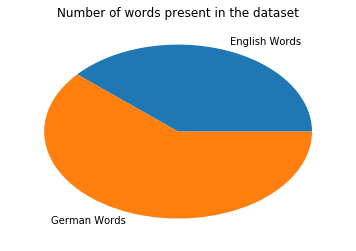

In [65]:
#Analysis of English and German Words
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Number of words present in the dataset')
x = [eng_vocab_size,ger_vocab_size]
plt.pie(x,labels = ['English Words','German Words'])

In [21]:
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

In [22]:
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

In [115]:
# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 256)           943616    
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 2315)           594955    
Total params: 2,589,195
Trainable params: 2,589,195
Non-trainable params: 0
_________________________________________________________________
None


In [116]:
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from numpy import argmax

In [117]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [118]:
# evaluate the skill of the model

from nltk.translate.bleu_score import SmoothingFunction
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        if i < 10:
            print('German: %s,\nCorrect English Translation=%s,\nPredicted English Translation=%s\n' % (raw_src, raw_target, translation))
        actual.append(raw_target.split())
        predicted.append(translation.split())
    # calculate BLEU score
    print('BLEU Score: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0),smoothing_function=SmoothingFunction().method4))
    

In [119]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

In [120]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])

In [121]:
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])

In [122]:
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

In [123]:
# test on some training sequences before training
print('TRAINING DATASET:\n')
evaluate_model(model, eng_tokenizer, trainX, train)

TRAINING DATASET:

German: ist das fur mich,
Correct English Translation=is it for me,
Predicted English Translation=punched punched punched punched punched

German: ich habe kaviar gegessen,
Correct English Translation=i ate caviar,
Predicted English Translation=for for for for for

German: das ist eine pflanze,
Correct English Translation=its a plant,
Predicted English Translation=foot brazil brazil brazil brazil

German: das ist ein tisch,
Correct English Translation=that is a table,
Predicted English Translation=having having having having having

German: sie schoss auf ihn,
Correct English Translation=she shot him,
Predicted English Translation=pick pick right right right

German: du bist durchtrieben,
Correct English Translation=youre sharp,
Predicted English Translation=warm slapped slapped slapped slapped

German: entledigen sie sich ihrer,
Correct English Translation=get rid of her,
Predicted English Translation=rice rice rice rice rice

German: rate wer ich bin,
Correct Engli

In [124]:
# test on some test sequences before training
print('TESTING DATASET:\n')
evaluate_model(model, eng_tokenizer, testX, test)

TESTING DATASET:

German: tom kennt pistolen,
Correct English Translation=tom knows guns,
Predicted English Translation=behave behave thief thief thief

German: tom ist brav,
Correct English Translation=tom is good,
Predicted English Translation=whose whose their their their

German: tom hat verloren,
Correct English Translation=tom lost,
Predicted English Translation=undressing undressing undressing undressing undressing

German: wer ist gefallen,
Correct English Translation=who fell,
Predicted English Translation=tell tell tell klutz klutz

German: tom kennt mich,
Correct English Translation=tom knows me,
Predicted English Translation=inside cost seven seven seven

German: sie sind wach,
Correct English Translation=theyre awake,
Predicted English Translation=obese obese obese obese obese

German: dort ist tom,
Correct English Translation=theres tom,
Predicted English Translation=pie after after after after

German: wir schauten nach oben,
Correct English Translation=we looked up,
Pre

In [125]:
#training the model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
 - 80s - loss: 3.9660 - val_loss: 3.4799

Epoch 00001: val_loss improved from inf to 3.47994, saving model to model.h5
Epoch 2/20
 - 69s - loss: 3.2947 - val_loss: 3.2883

Epoch 00002: val_loss improved from 3.47994 to 3.28833, saving model to model.h5
Epoch 3/20
 - 70s - loss: 3.0464 - val_loss: 3.1356

Epoch 00003: val_loss improved from 3.28833 to 3.13564, saving model to model.h5
Epoch 4/20
 - 71s - loss: 2.8106 - val_loss: 2.9747

Epoch 00004: val_loss improved from 3.13564 to 2.97471, saving model to model.h5
Epoch 5/20
 - 71s - loss: 2.6042 - val_loss: 2.8439

Epoch 00005: val_loss improved from 2.97471 to 2.84391, saving model to model.h5
Epoch 6/20
 - 69s - loss: 2.3833 - val_loss: 2.6791

Epoch 00006: val_loss improved from 2.84391 to 2.67905, saving model to model.h5
Epoch 7/20
 - 70s - loss: 2.1647 - val_loss: 2.5472

Epoch 00007: val_loss improved from 2.67905 to 2.54723, saving model to model.h5
Epoch 8/20
 - 70s 

In [126]:
# load model
model = load_model('model.h5')

In [127]:
# test on some training sequences after training
print('TRAINING DATASET:\n')
evaluate_model(model, eng_tokenizer, trainX, train)

TRAINING DATASET:

German: ist das fur mich,
Correct English Translation=is it for me,
Predicted English Translation=is it for me

German: ich habe kaviar gegessen,
Correct English Translation=i ate caviar,
Predicted English Translation=i ate caviar

German: das ist eine pflanze,
Correct English Translation=its a plant,
Predicted English Translation=its a plant

German: das ist ein tisch,
Correct English Translation=that is a table,
Predicted English Translation=thats a a

German: sie schoss auf ihn,
Correct English Translation=she shot him,
Predicted English Translation=she adores him

German: du bist durchtrieben,
Correct English Translation=youre sharp,
Predicted English Translation=youre sharp

German: entledigen sie sich ihrer,
Correct English Translation=get rid of her,
Predicted English Translation=get rid of her

German: rate wer ich bin,
Correct English Translation=guess who i am,
Predicted English Translation=save what i am

German: tom kann antworten,
Correct English Transla

In [128]:
# test on some test sequences after training
print('TESTING DATASET:\n')
evaluate_model(model, eng_tokenizer, testX, test)

TESTING DATASET:

German: tom kennt pistolen,
Correct English Translation=tom knows guns,
Predicted English Translation=tom knows her

German: tom ist brav,
Correct English Translation=tom is good,
Predicted English Translation=toms is

German: tom hat verloren,
Correct English Translation=tom lost,
Predicted English Translation=tom stopped

German: wer ist gefallen,
Correct English Translation=who fell,
Predicted English Translation=who swam

German: tom kennt mich,
Correct English Translation=tom knows me,
Predicted English Translation=tom knows me

German: sie sind wach,
Correct English Translation=theyre awake,
Predicted English Translation=theyre sharp

German: dort ist tom,
Correct English Translation=theres tom,
Predicted English Translation=here is tom

German: wir schauten nach oben,
Correct English Translation=we looked up,
Predicted English Translation=we tried again

German: kannst du mir helfen,
Correct English Translation=can you help me,
Predicted English Translation=can